In [ ]:
!pip install xgboost

In [ ]:
# pandas
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


In [7]:
# get expedia & test csv files as a DataFrame
train_df = pd.read_csv('./train.csv', nrows=10000)
test_df    = pd.read_csv('./test.csv', nrows=10000)
# destination = pd.read_csv('../input/destinations.csv', nrows=100000)

train_df.info()
print("----------------------------")
test_df.info()

# preview the data
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  10000 non-null  object 
 1   site_name                  10000 non-null  int64  
 2   posa_continent             10000 non-null  int64  
 3   user_location_country      10000 non-null  int64  
 4   user_location_region       10000 non-null  int64  
 5   user_location_city         10000 non-null  int64  
 6   orig_destination_distance  6271 non-null   float64
 7   user_id                    10000 non-null  int64  
 8   is_mobile                  10000 non-null  int64  
 9   is_package                 10000 non-null  int64  
 10  channel                    10000 non-null  int64  
 11  srch_ci                    9993 non-null   object 
 12  srch_co                    9993 non-null   object 
 13  srch_adults_cnt            10000 non-null  int6

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [12]:
# Function to convert date object into relevant attributes
def convert_date_into_days(df):
    df['srch_ci'] = pd.to_datetime(df['srch_ci'])
    df['srch_co'] = pd.to_datetime(df['srch_co'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[ns]')
    df['no_of_days_bet_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[ns]')
    
    # Check-in Month, Year, Day
    df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
    df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)

In [13]:
convert_date_into_days(train_df)
convert_date_into_days(test_df)

In [14]:
# Check the percentage of Nan in dataset
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

# Fill nan with the day which has max occurence
train_df['Cin_day'] = train_df['Cin_day'].fillna(26.0)
train_df['Cin_month'] = train_df['Cin_month'].fillna(8.0)
train_df['Cin_year'] = train_df['Cin_year'].fillna(2014.0)
train_df['stay_dur'] = train_df['stay_dur'].fillna(1.0)
train_df['no_of_days_bet_booking'] = train_df['no_of_days_bet_booking'].fillna(0.0)

# Fill average values in place for nan, fill with mean
train_df['orig_destination_distance'].fillna(train_df['orig_destination_distance'].mean(), inplace=True)

/var/folders/rt/0kf7v29569z7rctzmpst_dsh0000gn/T/ipykernel_48653/4049502888.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['orig_destination_distance'].fillna(train_df['orig_destination_distance'].mean(), inplace=True)


In [16]:
def understand_df_compact(df):
    # Dimensions of dataset
    print("———————————————————————————————————————————————————————————")
    print("Dimension of the dataset is", df.shape, "\n")

    # Summary of dataset
    print("———————————————————————————————————————————————————————————")
    print("Summary of the dataset is \n", df.describe(), "\n")

    print("———————————————————————————————————————————————————————————")
    print("Number of duplicates:")
    print(df.duplicated().sum())

    # Stats of dataset
    stats = []

    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Type'])
    print("———————————————————————————————————————————————————————————")

    print(f"Statistics of the dataset are \n {stats_df.sort_values('Percentage of missing values', ascending=False)}\n\n")

In [17]:
understand_df_compact(train_df)

———————————————————————————————————————————————————————————
Dimension of the dataset is (10000, 29) 

———————————————————————————————————————————————————————————
Summary of the dataset is 
                            date_time     site_name  posa_continent  \
count                          10000  10000.000000    10000.000000   
mean   2014-04-28 03:17:20.918200064      8.261400        2.744400   
min              2013-01-07 10:17:08      2.000000        0.000000   
25%    2014-01-09 10:53:37.249999872      2.000000        3.000000   
50%       2014-06-29 00:56:17.500000      2.000000        3.000000   
75%    2014-09-24 20:15:57.249999872     11.000000        3.000000   
max              2014-12-31 22:57:00     47.000000        4.000000   
std                              NaN     10.352004        0.590511   

       user_location_country  user_location_region  user_location_city  \
count           10000.000000          10000.000000        10000.000000   
mean               85.711700   

In [20]:
train_df.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      7
srch_co                      7
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
stay_dur                     0
no_of_days_bet_booking       0
Cin_day                      0
Cin_month                    0
Cin_year                     0
dtype: int64

In [21]:
train_df["srch_ci"].fillna(train_df["srch_ci"].mean(), inplace=True)
train_df["srch_co"].fillna(train_df["srch_co"].mean(), inplace=True)

/var/folders/rt/0kf7v29569z7rctzmpst_dsh0000gn/T/ipykernel_48653/1538709511.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["srch_co"].fillna(train_df["srch_co"].mean(), inplace=True)


Outliers

In [22]:
def winsorize_outliers(df):
    """
    Adjusts outliers in the DataFrame using the winsorizing method based on the IQR.

    Args:
    df (pd.DataFrame): DataFrame containing numerical data.

    Returns:
    pd.DataFrame: DataFrame with outliers adjusted.
    """
    # Iterate through each column in the DataFrame
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate Q1 and Q3
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        # Calculate Interquartile Range (IQR)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Winsorizing outliers
        df.loc[:,column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

In [23]:
train_df = winsorize_outliers(train_df)
test_df = winsorize_outliers(test_df)

/var/folders/rt/0kf7v29569z7rctzmpst_dsh0000gn/T/ipykernel_48653/1735016722.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2. 2. 2. ... 2. 2. 2.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,column] = df[column].clip(lower=lower_bound, upper=upper_bound)
/var/folders/rt/0kf7v29569z7rctzmpst_dsh0000gn/T/ipykernel_48653/1735016722.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[66. 66. 66. ... 66. 66. 66.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,column] = df[column].clip(lower=lower_bound, upper=upper_bound)
/var/folders/rt/0kf7v29569z7rctzmpst_dsh0000gn/T/ipykernel_48653/1735016722.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50. 50. 50. ... 

In [24]:
train_df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'stay_dur', 'no_of_days_bet_booking', 'Cin_day',
       'Cin_month', 'Cin_year'],
      dtype='object')

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define MAP@k metric
def mapk(actual, predicted, k=5):
    """
    Computes the Mean Average Precision at k (MAP@k).
    :param actual: List of true labels.
    :param predicted: List of predicted labels (ranked by probability).
    :param k: Number of top predictions to consider.
    :return: MAP@k score.
    """
    def apk(actual, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]
        score = 0.0
        num_hits = 0.0
        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)
        return score / min(len(actual), k)

    return np.mean([apk([a], p, k) for a, p in zip(actual, predicted)])


def xgboost_map_classification(data, target_col='hotel_cluster', features=None, k_values=[5], n_splits=5):
    """
    Trains an XGBoost model for multiclass classification using 5-fold cross-validation
    and evaluates it using MAP@k metrics. Plots a large confusion matrix after all folds.
    :param data: DataFrame containing the dataset.
    :param target_col: Name of the target column (default: 'hotel_cluster').
    :param features: List of feature column names. If None, all columns except the target are used.
    :param k_values: List of k values for MAP@k evaluation (default: [5]).
    :param n_splits: Number of folds for cross-validation (default: 5).
    """
    # Step 1: Prepare features and target
    if features is None:
        features = [col for col in data.columns if col != target_col]
    x = data[features]
    y = data[target_col]

    # Step 2: Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Step 3: Initialize variables to store results
    overall_map_scores = {f"MAP@{k}": [] for k in k_values}
    all_y_test = []
    all_y_pred_top1 = []
    fold = 1

    for train_index, test_index in skf.split(x, y):
        print(f"Fold {fold}/{n_splits}")
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Step 4: Initialize and train the XGBoost classifier
        model = XGBClassifier(objective="multi:softprob", num_class=len(np.unique(y)), eval_metric="mlogloss",
                              max_depth=8, random_state=0, n_jobs=-1)
        model.fit(x_train, y_train)

        # Step 5: Make predictions
        y_proba = model.predict_proba(x_test)  # Probabilities for each class
        y_pred = np.argsort(y_proba, axis=1)[:, ::-1]  # Sort predictions by probability (descending)

        # Step 6: Calculate MAP@k for each k in k_values
        fold_map_scores = {}
        for k in k_values:
            fold_map_scores[f"MAP@{k}"] = mapk(y_test.values, y_pred, k=k)
            overall_map_scores[f"MAP@{k}"].append(fold_map_scores[f"MAP@{k}"])

        # Print MAP@k scores for the current fold
        for k, score in fold_map_scores.items():
            print(f"Fold {fold} {k}: {score:.4f}")

        # Collect true and predicted labels for the confusion matrix
        all_y_test.extend(y_test.values)
        all_y_pred_top1.extend(y_pred[:, 0])  # Top-1 predictions

        fold += 1

    # Step 7: Calculate and print average MAP@k scores across all folds
    avg_map_scores = {k: np.mean(scores) for k, scores in overall_map_scores.items()}
    print("\nAverage MAP@k Scores Across All Folds:")
    for k, score in avg_map_scores.items():
        print(f"{k}: {score:.4f}")

    # Step 8: Plot the confusion matrix after all folds
    cm = confusion_matrix(all_y_test, all_y_pred_top1)
    plt.figure(figsize=(20, 16))  # Make the plot large to accommodate many clusters
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix (Aggregated Across All Folds)", fontsize=20)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return model, avg_map_scores

In [54]:
features = [t for t in train_df.columns if t not in ["date_time", "hotel_cluster"]]

In [32]:
train_df.dtypes

date_time                    datetime64[ns]
site_name                           float64
posa_continent                        int64
user_location_country               float64
user_location_region                  int64
user_location_city                    int64
orig_destination_distance           float64
user_id                               int64
is_mobile                             int64
is_package                            int64
channel                               int64
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt                       int64
srch_children_cnt                     int64
srch_rm_cnt                           int64
srch_destination_id                   int64
srch_destination_type_id              int64
is_booking                            int64
cnt                                   int64
hotel_continent                       int64
hotel_country                       float64
hotel_market                    

In [37]:
def preprocess_datetime_columns(data):
    """
    Converts all datetime columns in the dataset to numeric (float or int) format.
    :param data: DataFrame containing the dataset.
    :return: DataFrame with datetime columns converted to numeric format.
    """
    for col in data.columns:
        if pd.api.types.is_datetime64_any_dtype(data[col]) or data[col].dtype == 'object':
            try:
                # Attempt to parse the column as datetime
                data[col] = pd.to_datetime(data[col], errors='coerce')
                # Convert datetime to numeric (e.g., Unix timestamp)
                data[col] = data[col].map(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
            except Exception:
                # If parsing fails, leave the column as is
                pass
    return data

In [43]:
train_df = preprocess_datetime_columns(train_df)
test_df = preprocess_datetime_columns(test_df)

In [39]:
!pip install plotly

In [40]:
import plotly.express as px

Fold 1/5
Fold 1 MAP@5: 0.4367
Fold 2/5
Fold 2 MAP@5: 0.4235
Fold 3/5
Fold 3 MAP@5: 0.4237
Fold 4/5
Fold 4 MAP@5: 0.4295
Fold 5/5
Fold 5 MAP@5: 0.4197

Average MAP@k Scores Across All Folds:
MAP@5: 0.4266


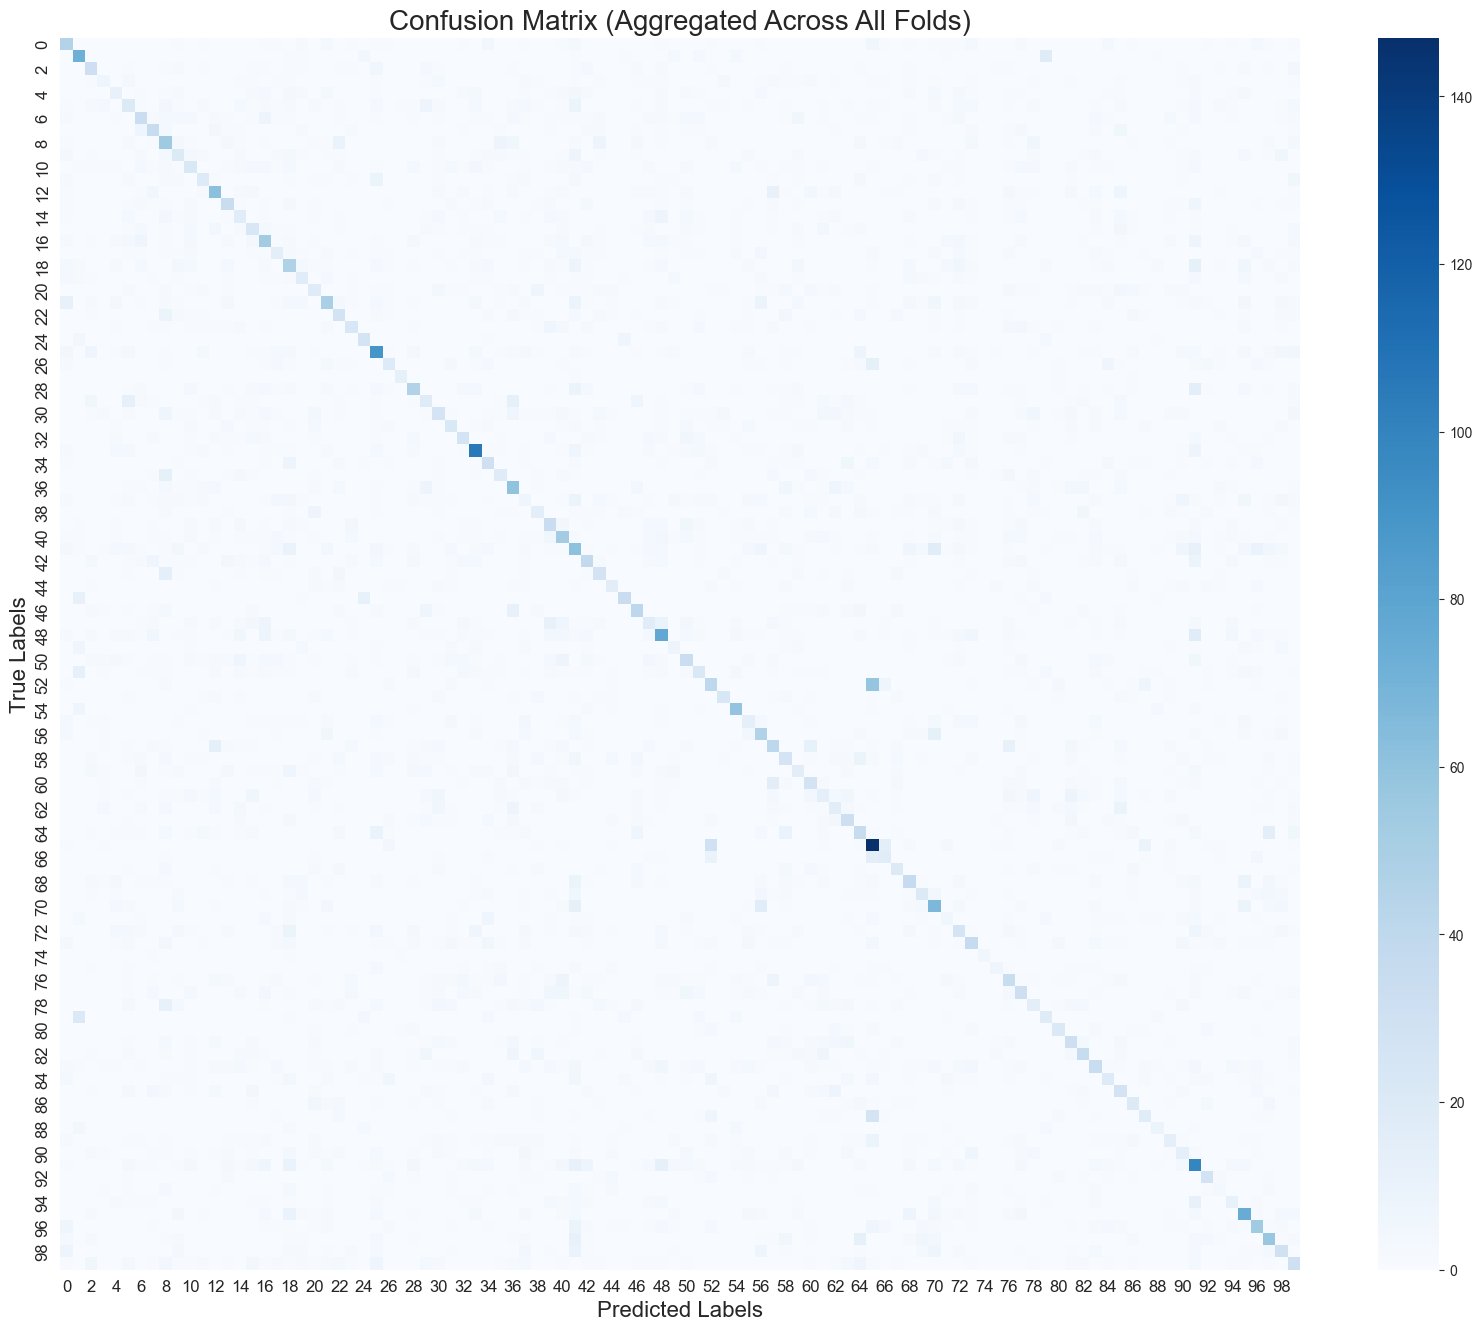

ValueError: not enough values to unpack (expected 4, got 2)

In [61]:
xgb, map_scores, y_pred, y_proba = xgboost_map_classification(train_df, target_col='hotel_cluster', features=features, k_values=[5])

In [62]:
def xgb_plot_feature_importance(model):
    """
    Plots the feature importance of an XGBoost model.
    :param model: Trained XGBoost model.
    :return: DataFrame of feature importances and a Plotly bar chart.
    """
    # Get feature names and importances
    feature_names = model.get_booster().feature_names  # Get feature names from the model
    feature_importances = model.feature_importances_  # Get feature importances

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

    # Plot feature importances using Plotly
    fig = px.bar(feature_importance_df, y="importance", x="feature", title="Feature Importance",
                 labels={"importance": "Importance", "feature": "Feature"}, text="importance")
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.update_layout(xaxis_tickangle=-45)

    # Show the plot
    fig.show()

    return feature_importance_df

In [63]:
feature_importance_df = xgb_plot_feature_importance(xgb)

In [64]:
feature_importance_df.columns

Index(['feature', 'importance'], dtype='object')

In [68]:
feature_importance_df["feature"][:10].to_list()

['hotel_continent',
 'hotel_country',
 'hotel_market',
 'user_id',
 'site_name',
 'Cin_month',
 'user_location_region',
 'user_location_country',
 'srch_destination_id',
 'srch_ci']